Подгружаю библиотеки и загружаю данные из датасета fetch_california_housing

In [14]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline


data = datasets.fetch_california_housing()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Реализую решающее дерево

In [4]:
class RegressionTree():

    def __init__(self, max_depth=3, min_size=10):
        
        self.max_depth = max_depth
        self.min_size = min_size
        #значение в поддереве (среднее по всем листам)
        self.value = 0
        # номер лучшего признака
        self.feature_idx = -1
        # значение лучшего признака
        self.feature_threshold = 0
        #правый и левый потомоки
        self.left = None
        self.right = None
        
    def fit(self, X, y):
        
        # начальное значение - среднее значение y
        self.value = y.mean()
        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        
        #одно из условий прекращения обучения: достигли максимальной глубины
        if self.max_depth <= 1:
            return
        
        left_value, right_value = 0.0, 0.0
        
        #перебираю всевозможные признаки и трешхолды
        for feat in range(X.shape[1]):
            
            prev_error1, prev_error2 = base_error, 0 
            idxs = np.argsort(X[:, feat])
            
            #более быстрый пересчет ошибки
            mean1, mean2 = y.mean(), 0
            sm1, sm2 = y.sum(), 0
            
            N = X.shape[0]
            N1, N2 = N, 0
            thres = 1
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1

                idx = idxs[thres]
                x = X[idx, feat]
                
                delta1 = (sm1 - y[idx]) * 1.0 / N1 - mean1
                delta2 = (sm2 + y[idx]) * 1.0 / N2 - mean2
                sm1 -= y[idx]
                sm2 += y[idx]
                
                # пересчитываем ошибки за O(1)
                prev_error1 += (delta1**2) * N1 
                prev_error1 -= (y[idx] - mean1)**2 
                prev_error1 -= 2 * delta1 * (sm1 - mean1 * N1)
                mean1 = sm1/N1
                
                prev_error2 += (delta2**2) * N2 
                prev_error2 += (y[idx] - mean2)**2 
                prev_error2 -= 2 * delta2 * (sm2 - mean2 * N2)
                mean2 = sm2/N2
                
                if thres < N - 1 and np.abs(x - X[idxs[thres + 1], feat]) < 1e-5:
                    thres += 1
                    continue
                
                #условия разделения: уменьшение ошибки и в кажом листе будет >= min_size
                if (prev_error1 + prev_error2 < error):
                    if (min(N1,N2) > self.min_size):
                        self.feature_idx, self.feature_threshold = feat, x
                        left_value, right_value = mean1, mean2
                        error = prev_error1 + prev_error2
                                     
                thres += 1
 
        #если не нашли разбияения
        if self.feature_idx == -1:
            return
        
        self.left = RegressionTree(self.max_depth - 1)
        self.right = RegressionTree(self.max_depth - 1)
        
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
    
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
    def __predict(self, x):
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, X):
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

In [5]:
%%time
A = RegressionTree(4, min_size=5)
A.fit(X,y)
test_mytree = A.predict(X)
test_mytree

CPU times: user 6.72 s, sys: 14.9 ms, total: 6.73 s
Wall time: 6.74 s


In [6]:
%%time
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5)
model.fit(X,y)
test_sklearn = model.predict(X)

CPU times: user 82.9 ms, sys: 0 ns, total: 82.9 ms
Wall time: 83.8 ms


Проверяю, что результат адекватный

In [7]:
rm = RegressionTree(max_depth=10, min_size=10)

In [8]:
rm.fit(X_train, y_train)

In [9]:
mse(rm.predict(X_test), y_test) / y_train.mean()

0.18616588295378705

Реализую градиентный бустинг

In [10]:
class GradientBoosting():
    
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3, 
                 random_state=17, min_size = 5):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0]])
        self.min_size = min_size
        self.loss_by_iter = []
        self.trees = []
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)
        
        prediction = b.copy()
            
        for t in range(self.n_estimators):  
            
            if t == 0:
                resid = y
            else:
                #вектор антиградиента
                resid = (y - prediction)
            
            tree = RegressionTree(max_depth=self.max_depth, min_size = self.min_size)
            tree.fit(X, resid)
            b = tree.predict(X).reshape([X.shape[0]])
            self.trees.append(tree)
            #учитываем learning_rate, чтобы увеличить обобщающую способность
            prediction += self.learning_rate * b
            
            if t > 0:
                self.loss_by_iter.append(mse(y,prediction))
                   
        return self
    
    def predict(self, X):
        
        # сначала прогноз – это просто вектор из средних значений ответов на обучении
        pred = np.ones([X.shape[0]]) * np.mean(self.y)
        # добавляем прогнозы деревьев с учётом learning_rate при обучении
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees[t].predict(X).reshape([X.shape[0]])
            
        return pred

Смотрю, что с добавлением следующего решающего дерева Loss действительно падает

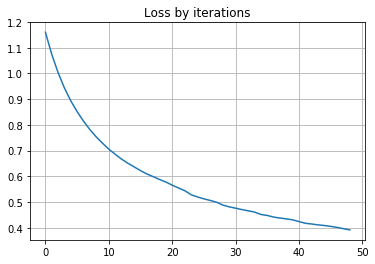

In [15]:
GDB = GradientBoosting(n_estimators=50)
GDB.fit(X,y)
x = GDB.predict(X)
plt.grid()
plt.title('Loss by iterations')
plt.plot(GDB.loss_by_iter)

Обучается ~5 минут, снова проверяю результат на адекватность

In [50]:
gb = GradientBoosting()
gb.fit(X_train, y_train)
mse(gb.predict(X_test), y_test) / y_test.mean()

Сравнение с scikit learn GDBSklearn

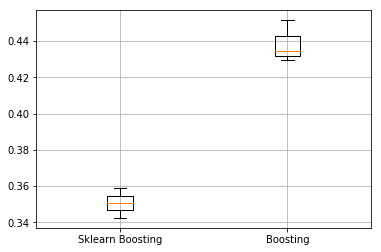

In [18]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor as GDBSklearn
import copy


def get_metrics(X,y,n_folds=2, model=None):
    kf = KFold(n_splits=n_folds, shuffle=True)
    kf.get_n_splits(X)

    er_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        predict = model.predict(X_test)
        er_list.append(mse(y_test, predict))
    
    return er_list

data = datasets.fetch_california_housing()
X = np.array(data.data)
y = np.array(data.target)
er_boosting = get_metrics(X,y,3,GradientBoosting(max_depth=3, n_estimators=40))
er_sklearn_boosting = get_metrics(X,y,3,GDBSklearn(max_depth=3,n_estimators=40, learning_rate=0.1))

%matplotlib inline
data = [er_sklearn_boosting, er_boosting]
fig7, ax7 = plt.subplots()
ax7.set_title('')
ax7.boxplot(data, labels=['Sklearn Boosting', 'Boosting'])
plt.grid()
plt.show()